In [1]:
# function for cbf and Tmax
from multiprocessing import Pool 
from skimage.morphology import medial_axis
from skimage.filters.rank import median
from skimage.morphology import disk
from scipy import ndimage
from scipy import linalg
from scipy.stats import pearsonr,linregress
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt 
import pydicom 
from pydicom import dcmread
import cv2

def cross0lag(a, b):
    return np.dot(a, b) / np.sqrt(np.dot(a, a) * np.dot(b, b))

def corr_lag_cbf(roi,slice):
    
    slice_sum = np.min(slice,axis=0)
    image1copy = np.uint8(slice_sum)
    vessel_mask = cv2.adaptiveThreshold(image1copy,1,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,101,5)
    vessel_mask = 1-vessel_mask
    vessel_mask = cv2.normalize(vessel_mask, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    # smooth
    blobs = vessel_mask
    blobs = median(blobs,disk(4))

    # Compute the medial axis (skeleton) and the distance transform
    # modified usr/local/anaconda3/lib/python3.7/site-packages/skimage/morphology/_skeletonize.py
    # Build distance transform
    #distance = ndi.distance_transform_edt(masked_image)-->distance, inds = ndi.distance_transform_edt(masked_image, return_indices=True)
    # inds is the coordinator of pixel which has the 'distance' with pixels in 'distance'
    skel, distance,inds = medial_axis(blobs, return_distance=True)

    # flipping skeleton
    skel_reverse = 1-skel

    # calculate distance to skeleton and then thickness of vessel            
    dist_to_skel = ndimage.distance_transform_edt(skel_reverse)
    dist_to_skel_masked = dist_to_skel*vessel_mask
    thickness = 2*np.sqrt((dist_to_skel_masked+distance)**2-dist_to_skel_masked**2) 

    # real thickness(mm)
    real_thickness = thickness * float(img.ImagerPixelSpacing[0])

    # thickness correction
    ## slice is the intensity, and 
    thickness_min = np.min(thickness[thickness>0])
    brain_mask = 1-vessel_mask # vessel is 0, brain is 1
    brain = (np.zeros((brain_mask.shape[0],brain_mask.shape[1]))+thickness_min)*brain_mask
    vessel = thickness/3.5  #need phantom calibration
    #https://www.ncbi.nlm.nih.gov/core/lw/2.0/html/tileshop_pmc/tileshop_pmc_inline.html?title=Click%20on%20image%20to%20zoom&p=PMC3&id=2780468_MPHYA6-000036-005347_1-g008.jpg
    #https://pubmed.ncbi.nlm.nih.gov/19994543/

    thickness_correction = brain + vessel
    thickness_correction[thickness_correction==0]=thickness_min  #fill some holes
    concentration=np.empty((slice.shape[0],slice.shape[1],slice.shape[2]))

    for i in range(0, slice.shape[0]):        
        concentration[i,:,:] = slice[i,:,:]/thickness_correction
        #concentration[i,:,:] = slice[i,:,:]

    ## extract mean value in the ROI
    time_course=np.empty((roi.shape[0],concentration.shape[0]))
    slice_time_course=np.empty((roi.shape[0],concentration.shape[0]))
    for j in range(concentration.shape[0]):
        for i in range(roi.shape[0]):
            time_course[i,j]=np.mean(concentration[j,roi[i,0,1]:roi[i,1,1],roi[i,0,0]:roi[i,1,0]])
            slice_time_course[i,j]=np.mean(slice[j,roi[i,0,1]:roi[i,1,1],roi[i,0,0]:roi[i,1,0]])

    Ca = linalg.toeplitz(-time_course[0,:])
    Ca = np.tril(Ca)
    U, W, Vt = np.linalg.svd(Ca, full_matrices=True)
    threshold = -np.sort(-W[W!=0])
    W = np.diag(W)
    W[W<threshold[3]]=0
    W_inv = np.linalg.pinv(W)

    CBF = np.empty((concentration.shape[1],concentration.shape[2]))
    Tmax = np.empty((concentration.shape[1],concentration.shape[2]))
    for i in range(slice.shape[1]):
        for j in range(slice.shape[2]):
            Cu = np.reshape(-concentration[:,i,j],(concentration.shape[0],1))
            R = ((Vt.T.dot(W_inv)).dot(U.T)).dot(Cu)
            CBF[i,j] = np.max(R)
            Tmax[i,j] = np.argmax(R)
    Tmax = Tmax*1/2.5
    
    Tmax_raw = Tmax*2.5

    Corr = np.empty((slice.shape[1],slice.shape[2]))
    Corr_p = np.empty((slice.shape[1],slice.shape[2]))
    Corr_sig = np.empty((slice.shape[1],slice.shape[2]))
    Corr_se = np.empty((slice.shape[1],slice.shape[2]))

    for i in range(slice.shape[1]):
        for j in range(slice.shape[2]):
            if Tmax[i,j] < 9:
                shift = np.int(Tmax_raw[i,j])
                if shift == 0:
                    Corr[i,j] = cross0lag(time_course[0,:],concentration[:,i,j])
                else:
                    Corr[i,j] = np.dot(time_course[0,:-shift],concentration[shift:,i,j])/np.sqrt(np.dot(time_course[0,:], time_course[0,:]) * np.dot(concentration[:,i,j], concentration[:,i,j]))
            else:
                Corr[i,j] = 0

                        

    return CBF,Tmax,Corr


25


/tmp/ipykernel_13850/4283687867.py:30: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  blobs = median(blobs,disk(4))
/tmp/ipykernel_13850/4283687867.py:103: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  shift = np.int(Tmax_raw[i,j])
/tmp/ipykernel_13850/4283687867.py:18: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(a, b) / np.sqrt(np.dot(a, a) * np.dot(b, b))


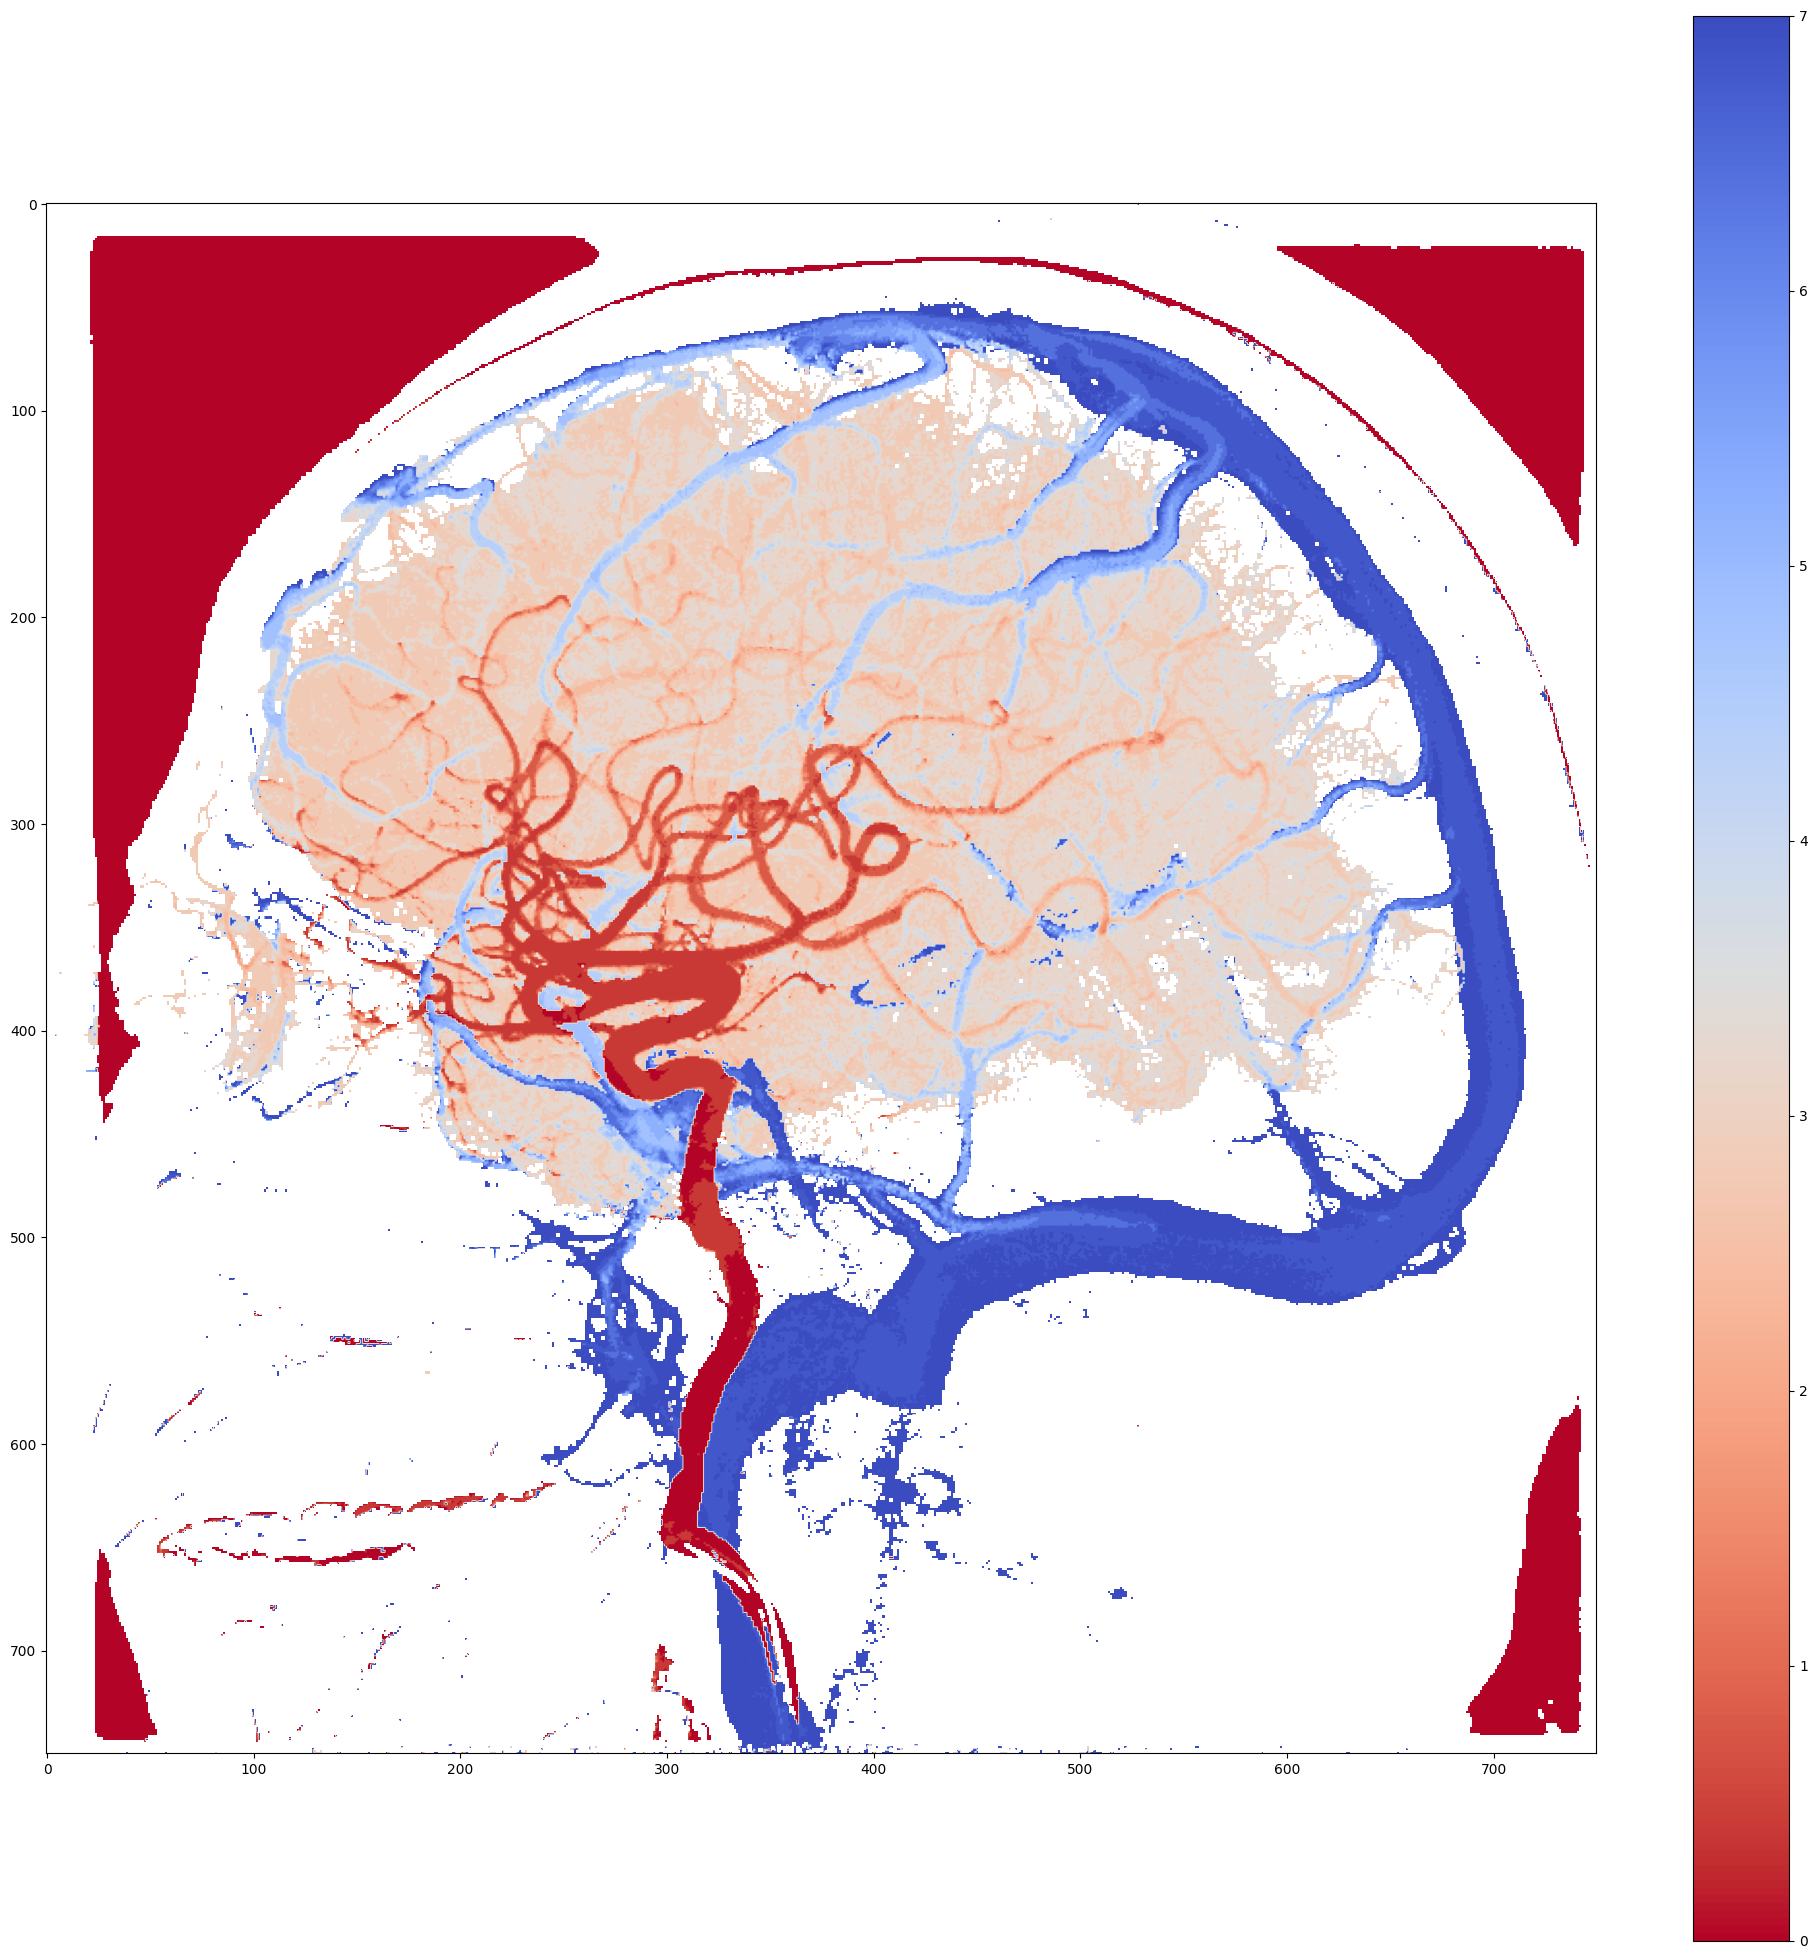

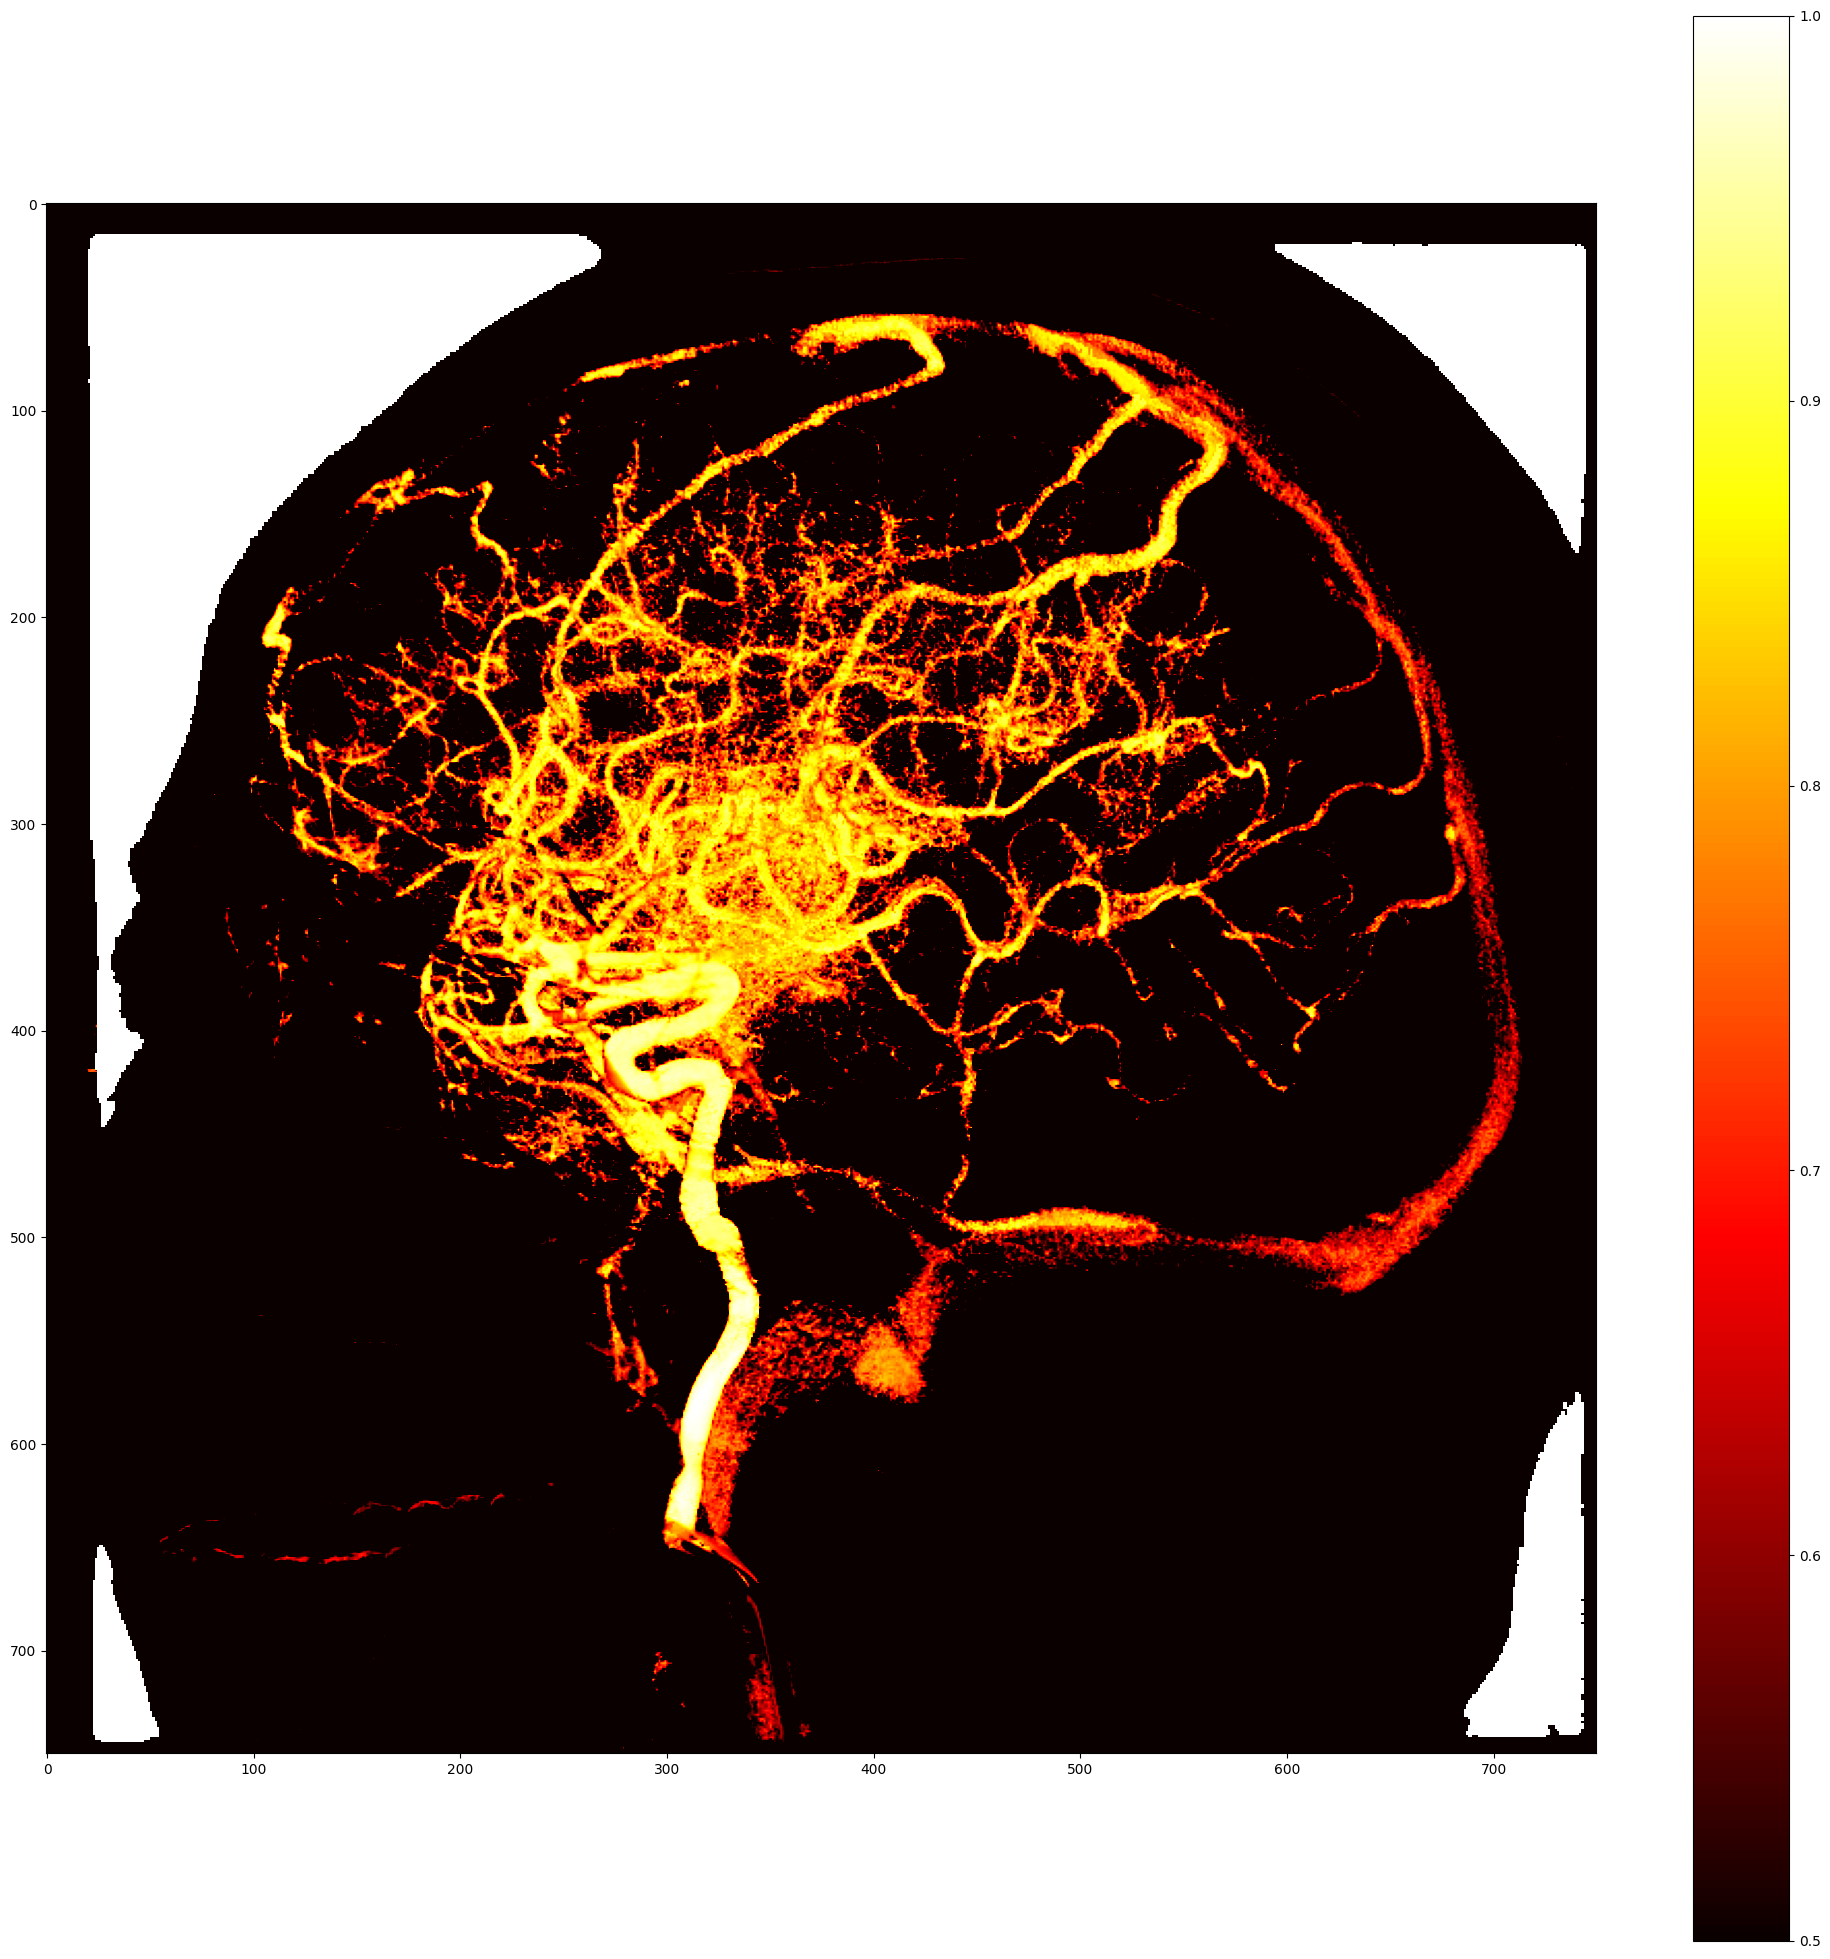

In [3]:
# extract and unzip the ImageFileName05.tar.xz
# input as DICOM in the following dcmread
right_img_sag = dcmread('./ImageFileName05.dcm')

#choose any image above

img = right_img_sag
imgname = 'example'

slice=np.empty((img.pixel_array.shape[0],img.pixel_array.shape[1],img.pixel_array.shape[2]))

for i in range(0,img.pixel_array.shape[0]):        
    slice[i,:,:]=-np.array(img.pixel_array[0,:,:],dtype=np.int32)+np.array(img.pixel_array[i,:,:],dtype=np.int32)
slice = slice[:25,:,:] 
print(slice.shape[0])    
# choose roi
cv2.destroyAllWindows()  
slice_sum = np.min(slice,axis=0)

start, end = (0, 0), (0, 0)
drawing = False
n = 0
roi = np.empty((1,2,2),dtype=int)

# mask
slice_sum_normed = cv2.normalize(slice_sum, None, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
def mouse_event(event, x, y, flags, param):
    global start, drawing, end, temp, point1_x, point1_y, point2_x, point2_y,n

    # press left-click of mouse
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        start = (x, y)
        point1_x = x
        point1_y = y
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            end = (x, y)
    # release left-click of mouse
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        cv2.rectangle(slice_sum_normed, start, (x, y), (255,0, 0), 2)
        start = end = (0, 0)       
        point2_x = x
        point2_y = y
        
        roi[n,:,:]=[[point1_x,point1_y],[point2_x,point2_y]]
        n+=1        
cv2.namedWindow('image')
cv2.setMouseCallback('image', mouse_event)
while(True):
    temp = np.copy(slice_sum_normed)
    if(drawing and end != (0, 0)):
        cv2.rectangle(temp, start, end, (255, 0, 0), 2)
    cv2.resizeWindow('image', 1000,1000)     
    cv2.imshow('image', temp)
    if cv2.waitKey(20) == 27:
        break

cv2.waitKey()
cv2.destroyAllWindows()

        
CBF,Tmax,Corr = corr_lag_cbf(roi,slice)

slice_sum = np.min(slice,axis=0)


plt.style.use('default')


Tmax_masked = np.ma.masked_where(Tmax>9, Tmax) 
Tmax_masked = np.ma.masked_where(Tmax_masked==-1, Tmax_masked) 
plt.figure(figsize=(25,25))
color_map = plt.cm.get_cmap('coolwarm')
reversed_color_map = color_map.reversed()
plt.imshow(Tmax_masked,vmin=0,vmax=7,cmap=reversed_color_map)
plt.colorbar() 


plt.figure(figsize=(25,25))
plt.imshow(Corr,vmin=0.5,vmax=1,cmap='hot')
plt.colorbar() 

plt.show()

